In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import torch
from importlib import reload
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

498125


In [2]:
library_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF2_4T1Primary'


In [3]:
target_gene_mean_exp_filename = os.path.join(library_folder, 'marker_gene_mean_exp.csv')
gene_mean_exp_df = pd.read_csv(target_gene_mean_exp_filename).rename({'Unnamed: 0':'Name'},axis=1).set_index('Name')
target_gene_umi_frac_filename = os.path.join(library_folder, 'marker_gene_umi_frac.csv')
gene_umi_frac_df = pd.read_csv(target_gene_umi_frac_filename).rename({'Unnamed: 0':'Name'},axis=1).set_index('Name')

celltype_num_filename = os.path.join(library_folder, 'celltype_num.csv')
celltype_num = pd.read_csv(celltype_num_filename).set_index('Unnamed: 0')
# 
# The output codebook filename
codebook_file = os.path.join(library_folder, 'codebook.csv')
# load kept_genes
kept_gene_filename = os.path.join(library_folder, 'kept_gene_info.csv')
kept_gene_df = pd.read_csv(kept_gene_filename).rename({'Unnamed: 0':'Name'},axis=1).set_index('Name')

In [4]:
_groups = np.unique(list(kept_gene_df['Group']) + ['blank'])

In [5]:
kept_gene_df

,Transcript,Num_Candidate_Probes,Group,Neutrophil_mN1_Gr1_low,Neutrophil_mN1_lung,B_cell,Macrophage,Neutrophil_mN6,Monocyte,Neutrophil_mN5_mN3,...,4T1_Hmga2_high,Endothelial,Tcell_CD8_exhausted,cDC1,Fibroblast,Hepatocyte,pDC,4T1_Nestin_high,Tcell_gamma_delta,ILC
Name,,,,,,,,,,,,,,,,,,,,,
Trdc,ENSMUST00000196323.2,2002,Tcell_gamma_delta,0.001265,0.000746,0.005766,0.003817,0.001539,0.000579,0.000000,...,0.000950,0.015243,0.007407,0.002408,0.010699,0.000000,0.000000,0.000000,1.242275,0.065402
Ighd,ENSMUST00000194162.6,916,B_cell,0.005038,0.002149,0.899805,0.006848,0.003647,0.003574,0.000431,...,0.000000,0.011424,0.000000,0.009489,0.000000,0.014535,0.039486,0.000000,0.000000,0.000000
Ighm,ENSMUST00000177715.8,1115,B_cell,0.205147,0.116890,3.079702,0.086627,0.224392,0.322190,0.012634,...,0.005535,0.296212,0.113855,0.827244,0.018162,0.648157,2.036214,0.000000,0.277366,0.148772
Gramd3,ENSMUST00000237355.2,1339,Tcell_CD8_memory,0.014021,0.018353,0.833495,0.067402,0.024259,0.075371,0.006781,...,0.149769,0.184072,1.408295,0.206109,0.124862,0.128767,0.161856,0.008005,0.552079,0.028583
Aldh7a1,ENSMUST00000066208.13,1324,Fibroblast,0.002138,0.002872,0.125186,0.018453,0.011303,0.004022,0.002449,...,0.128507,0.056699,0.039886,0.010037,0.413623,0.393636,0.023820,0.315688,0.026171,0.015686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D430036J16Rik,ENSMUST00000181893.9,998,Basophil,0.000000,0.000284,0.000918,0.000802,0.000120,0.000697,0.000000,...,0.000717,0.000000,0.000000,0.004164,0.000000,0.000000,0.000000,0.003715,0.000000,0.189079
1700047M11Rik,ENSMUST00000189594.2,1117,Neutrophil_mN1_liver,0.024250,0.177883,0.013694,0.016808,0.126880,0.013320,0.019411,...,0.000659,0.134595,0.000000,0.014943,0.015308,0.024795,0.022166,0.000000,0.000000,0.000000
4933440M02Rik,ENSMUST00000061823.3,2059,Myeloid_progenitor,0.003742,0.000702,0.002096,0.000923,0.001680,0.001303,0.000000,...,0.000000,0.000000,0.008192,0.006762,0.000000,0.000000,0.010416,0.000000,0.000000,0.000000


In [6]:
num_genes = len(kept_gene_df)
print(num_genes)

746


# load codebook

## load covering design

In [7]:
# analysis 
from ChromAn.src.library_tools.design_codebook import barcode_to_matrix, HammingDist_for_matrix, remove_bad_barcodes

In [8]:
covering_folder = '/lab/solexa_weissman/puzheng/References/Encoding_Design'
#covering_folder = r'Y:\References\Encoding_Design' # mapped this folder in Windows

num_bits = 28
hamming_weight = 4
hamming_distance = 4


covering_design_filename = os.path.join(covering_folder, f'covering_v{num_bits}_k{hamming_weight}_t{int(hamming_weight + 1 - (hamming_distance / 2))}.txt')
print(covering_design_filename)
design_df = pd.read_csv(covering_design_filename, header=None, delimiter='\s+')
print(len(design_df))
design_barcodes = design_df.values - 1

design_matrix = barcode_to_matrix(design_barcodes)


/lab/solexa_weissman/puzheng/References/Encoding_Design/covering_v28_k4_t3.txt
819


minimum hamming distance: 4


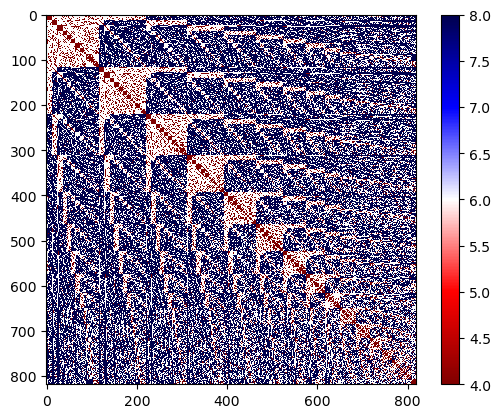

In [9]:
# check hamming distances
distmat = HammingDist_for_matrix(design_matrix)
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(distmat, cmap='seismic_r', vmin=4, vmax=8, interpolation='nearest')
plt.colorbar()
plt.show()

In [10]:
# reduce map if necessary
reduced_design_barcodes = remove_bad_barcodes(design_barcodes, 
                                              min_hamming_dist=hamming_distance)
code_length = len(np.unique(reduced_design_barcodes))

minimum hamming distance: 4


# Select subset of possible codes

from MERFISH_probe_design.hamming_codes import code_selection, hamming_code_analysis
import MERFISH_probe_design.codebook_design.codebook_design_stochastic as cds
import MERFISH_probe_design.IO.file_io as fio

## optimization principles:
1. std of each

In [11]:
from tqdm import tqdm
# Initialize codes:
def _optimizer_group_stderr(_gene_group_df, _gene_code_df):
    _groups, _group_sizes = np.unique(_gene_group_df['Group'], return_counts=True)
    _valid_groups = [_g for _g in _groups if _g.lower() != 'blank']
    _optimizers = []
    for _group in _groups:
        _group_exp_df = _gene_group_df.loc[_gene_group_df['Group'] == _group, _valid_groups]
        _group_code_df = _gene_code_df.loc[_gene_group_df['Group'] == _group]
        # Group optimizer:
        _group_exp_vector = (_group_exp_df.values.transpose() @ _group_code_df.values).sum(0)
        _group_exp_stderr = np.std(_group_exp_vector) / np.mean(_group_exp_vector)
        _optimizers.append(_group_exp_stderr)
    return np.array(_optimizers)

def _group_bit_mean_exp(_gene_group_df, _gene_code_df):
    _groups, _group_sizes = np.unique(_gene_group_df['Group'], return_counts=True)
    _valid_groups = [_g for _g in _groups if _g.lower() != 'blank']
    _mean_exps = []
    for _group in _groups:
        _group_exp_df = _gene_group_df.loc[_gene_group_df['Group'] == _group, _valid_groups]
        _group_code_df = _gene_code_df.loc[_gene_group_df['Group'] == _group]
        # Group optimizer:
        _group_exp_vector = (_group_exp_df.values.transpose() @ _group_code_df.values).sum(0)
        _mean_exps.append(_group_exp_vector)
    return pd.DataFrame(_mean_exps, columns=_gene_code_df.columns, index=_groups)

def swap_code(gene_code_df, gene_group_df, i, j):
    _gene_code_df = gene_code_df.copy()
    _gene_code_df.iloc[i], _gene_code_df.iloc[j] =  _gene_code_df.iloc[j].copy(), _gene_code_df.iloc[i].copy()
    # compare optimizer:
    _old_optimizer = _optimizer_group_stderr(gene_group_df, gene_code_df)
    _new_optimizer = _optimizer_group_stderr(gene_group_df, _gene_code_df)
    if np.sum(_new_optimizer) - np.sum(_old_optimizer) < 0:
        return _gene_code_df
    else:
        return gene_code_df
    
def shuffle_group_codes(gene_code_df, gene_group_df, group, n_iters=100, verbose=False):
    # skip blank
    #if group.lower() == 'blank':
    #    return gene_code_df
    _group = group
    _gene_code_df = gene_code_df.copy()
    _groups, _group_sizes = np.unique(gene_group_df['Group'], return_counts=True)
    _valid_groups = [_g for _g in _groups if _g.lower() != 'blank']
    # calculate current optimizer:
    _min_optimizer = _optimizer_group_stderr(gene_group_df, _gene_code_df)[list(_groups).index(_group)]
    if verbose:
        print(f"- shuffle group: Start={_min_optimizer:.5f}", end=', ')
    _group_codes = _gene_code_df.loc[gene_group_df['Group'] == _group].values # get current group_code
    _group_exp_df = gene_group_df.loc[gene_group_df['Group'] == _group, _valid_groups]
    for _iter in range(n_iters):
        # Group optimizer:
        _group_exp_vector = (_group_exp_df.values.transpose() @ _group_codes).sum(0)
        _group_exp_stderr = np.std(_group_exp_vector) / np.mean(_group_exp_vector)
        if np.isfinite(_group_exp_stderr) and _group_exp_stderr < _min_optimizer:
            #print(_iter, f"{_group_exp_stderr:.5f}")
            _min_optimizer = _group_exp_stderr
            _gene_code_df.loc[gene_group_df['Group'] == _group] = _group_codes
        # shuffle
        np.random.shuffle(_group_codes)
    if verbose:
        print(f"End={_min_optimizer:.5f} after {n_iters}-iters.")
    return _gene_code_df
    
    
def barcode_to_matrix(barcodes, num_bits=None):
    try:
        _num_bits = int(num_bits)
    except:
        _num_bits = max(len(np.unique(barcodes)), np.max(barcodes)+1)
    _matrix = np.zeros([len(barcodes), _num_bits], dtype=np.int32)
    for _i, _b in enumerate(barcodes):
        _matrix[_i][_b] = 1
    return _matrix
def generate_random_partition(candidate_codes, group_sizes):
    _codes = np.array(candidate_codes).copy()
    np.random.shuffle(_codes)
    _group_codes, _rest_codes = [], []
    _start = 0
    for _i, _gs in enumerate(group_sizes):
        _group_codes.append(_codes[_start:_start+_gs])
        _start += _gs
    # rest
    _rest_codes = _codes[_start:]
    return _group_codes, _rest_codes
    
    
    
def Select_optimized_barcodes(reduced_design_barcodes, kept_gene_df, 
                              shuffle_n_iters = 1000, swap_n_iters = 100, total_n_iters = 10,
                              verbose=True,
                              ):
    # Internalize params
    _candidate_barcodes = reduced_design_barcodes.copy()
    _candidate_codes = barcode_to_matrix(_candidate_barcodes)
    _num_bits = np.max(_candidate_barcodes) + 1 # assume barcode start as 1
    # group and expression
    _gene_group_df = kept_gene_df.copy()
    _mean_exp = np.mean(_gene_group_df[np.unique(_gene_group_df['Group'])].values)
    # append blank
    _blank_names = [f"blank-{_ib}" for _ib in range(len(_candidate_barcodes) - len(_gene_group_df))]
    _blank_group_df = pd.DataFrame(columns=_gene_group_df.columns, index=_blank_names)
    _blank_group_df['Group'] = 'blank'
    _gene_code_df = pd.DataFrame(columns=np.unique(_candidate_barcodes), index=list(_gene_group_df.index)+list(_blank_names)).fillna(0) 
    _gene_group_df = pd.concat([_gene_group_df, _blank_group_df], axis=0).fillna(_mean_exp/2)
    # find groups
    _groups, _group_sizes = np.unique(_gene_group_df['Group'], return_counts=True)
    #_valid_groups = [_g for _g in _groups if _g.lower() != 'blank']

    # random generate
    _group_codes_list, _rest_codes = generate_random_partition(_candidate_codes, _group_sizes)
    # first assign:
    for _group, _group_codes in zip(_groups, _group_codes_list):
        _gene_code_df.loc[_gene_group_df['Group'] == _group] = _group_codes
    # save init scores
    init_mean_exp_df = _group_bit_mean_exp(_gene_group_df, _gene_code_df)
    # print current status
    _init_optimizer = _optimizer_group_stderr(_gene_group_df, _gene_code_df)
    print(np.round(_init_optimizer, 5))
    
    for _total_iter in range(total_n_iters):
        # shuffle within groups
        for _group in _groups:
            _gene_code_df = shuffle_group_codes(_gene_code_df, _gene_group_df, _group, n_iters=shuffle_n_iters)
        # swap
        for _iter in tqdm(range(swap_n_iters)):
            _gene_code_df = swap_code(_gene_code_df, _gene_group_df, *np.random.randint(0, len(_gene_group_df), 2))
        # print current status
        _curr_optimizer = _optimizer_group_stderr(_gene_group_df, _gene_code_df)
        print(np.round(_curr_optimizer, 5))

    # final evaluation
    mean_exp_df = _group_bit_mean_exp(_gene_group_df, _gene_code_df)
    # return
    return _gene_group_df, _gene_code_df, init_mean_exp_df, mean_exp_df

In [12]:
_gene_group_df, _gene_code_df, init_mean_exp_df, mean_exp_df = Select_optimized_barcodes(reduced_design_barcodes, kept_gene_df)

[0.36336 1.25245 0.71544 0.63792 0.40329 0.34179 0.90578 0.70934 0.68336
 0.77707 0.3683  1.39315 0.7455  0.78498 0.89933 1.10426 0.88264 0.73902
 1.15517 0.73078 0.69807 0.66327 0.65885 0.82936 0.27053 0.86434 0.49977]


100%|██████████| 100/100 [00:07<00:00, 14.19it/s]


[0.24909 1.2231  0.42083 0.44673 0.29605 0.24263 0.70304 0.55019 0.44973
 0.50255 0.22029 1.38026 0.59959 0.59758 0.65845 0.71896 0.54386 0.5392
 0.98    0.50509 0.48167 0.51665 0.4226  0.57682 0.2284  0.74554 0.35408]


100%|██████████| 100/100 [00:06<00:00, 14.60it/s]


[0.21979 1.22715 0.38073 0.43779 0.23595 0.22054 0.67219 0.54007 0.43751
 0.49138 0.20631 1.3802  0.5557  0.59758 0.65653 0.64819 0.5235  0.53334
 0.92579 0.50509 0.43065 0.46999 0.37112 0.55452 0.2284  0.69495 0.35408]


100%|██████████| 100/100 [00:06<00:00, 14.63it/s]


[0.19055 1.22706 0.37222 0.40477 0.22109 0.21377 0.67765 0.54007 0.37677
 0.44892 0.17588 1.3801  0.52508 0.59758 0.65653 0.62696 0.52116 0.53271
 0.92406 0.50416 0.42417 0.4488  0.37298 0.54789 0.20086 0.69616 0.35408]


100%|██████████| 100/100 [00:06<00:00, 14.62it/s]


[0.1926  1.21312 0.37222 0.38979 0.19353 0.21764 0.67533 0.52855 0.35013
 0.41271 0.16898 1.3801  0.49113 0.59627 0.65653 0.62696 0.51983 0.52323
 0.86198 0.47403 0.42417 0.44586 0.37298 0.52226 0.19251 0.69616 0.3491 ]


100%|██████████| 100/100 [00:06<00:00, 14.62it/s]


[0.20469 1.21386 0.36417 0.38842 0.13616 0.21153 0.62901 0.5272  0.35013
 0.35789 0.16216 1.35691 0.49113 0.59627 0.65028 0.62342 0.51983 0.4898
 0.80653 0.47403 0.3623  0.42125 0.37268 0.56119 0.18018 0.69106 0.33908]


100%|██████████| 100/100 [00:06<00:00, 14.61it/s]


[0.19257 1.21542 0.3447  0.38296 0.12106 0.20774 0.62901 0.50013 0.34889
 0.34221 0.1625  1.35651 0.4702  0.55271 0.62987 0.62342 0.49271 0.4898
 0.80653 0.44679 0.33507 0.42221 0.34688 0.52864 0.18907 0.67759 0.32613]


100%|██████████| 100/100 [00:06<00:00, 14.44it/s]


[0.18883 1.20867 0.33832 0.38365 0.11255 0.19889 0.62901 0.48235 0.34881
 0.30846 0.16092 1.35651 0.4702  0.53199 0.62811 0.62342 0.46254 0.4898
 0.80439 0.448   0.33565 0.42161 0.34343 0.51591 0.15887 0.67679 0.31765]


100%|██████████| 100/100 [00:06<00:00, 14.61it/s]


[0.18733 1.20867 0.33192 0.37603 0.10749 0.20698 0.62886 0.46788 0.34319
 0.30029 0.15925 1.35651 0.4702  0.53199 0.62663 0.62342 0.46254 0.4898
 0.7997  0.448   0.33565 0.38856 0.33115 0.44009 0.15679 0.67679 0.31458]


100%|██████████| 100/100 [00:06<00:00, 14.49it/s]


[0.16658 1.20286 0.33012 0.36791 0.102   0.19031 0.62886 0.4175  0.30793
 0.30029 0.16575 1.35651 0.46081 0.45829 0.62538 0.6063  0.46176 0.49445
 0.7997  0.448   0.33565 0.37792 0.32586 0.44009 0.13175 0.67211 0.28766]


100%|██████████| 100/100 [00:06<00:00, 14.62it/s]


[0.16579 1.20173 0.32961 0.36791 0.09213 0.18726 0.62217 0.40183 0.30793
 0.29476 0.15691 1.35651 0.44944 0.45829 0.62415 0.6063  0.46176 0.49573
 0.7997  0.44711 0.33565 0.37101 0.32586 0.44009 0.11863 0.66209 0.28823]


%%time
import multiprocessing as mp
with mp.Pool(12) as _pool:
    results = _pool.starmap(Select_optimized_barcodes,
                            [(reduced_design_barcodes, kept_gene_df, 1000, 100, 1) for _i in range(12)], chunksize=1)
    _pool.close()
    _pool.join()
    _pool.terminate()

## Plot design criteria

In [13]:
_groups = np.unique(list(kept_gene_df['Group']) + ['blank'])

figure_folder = os.path.join(library_folder, 'figures')
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)
import time
import seaborn as sns


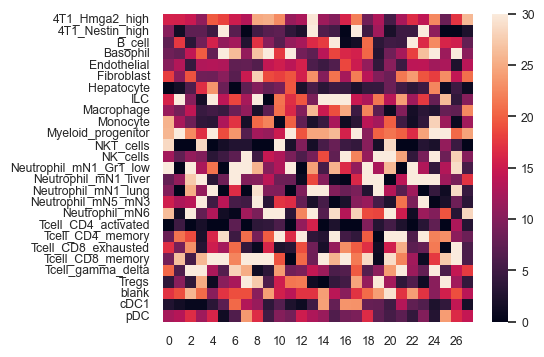

In [14]:
sns.set(font_scale=0.8) 
fig, ax = plt.subplots(figsize=(5,4), dpi=100)
sns.heatmap(init_mean_exp_df,ax=ax, annot=False, annot_kws={'size': 3},
            yticklabels=_groups, vmin=0, vmax=30)
plt.savefig(os.path.join(figure_folder, 
                         f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_mean_exp_by_bit_init.png"), 
            transparent=True)
fig.show()

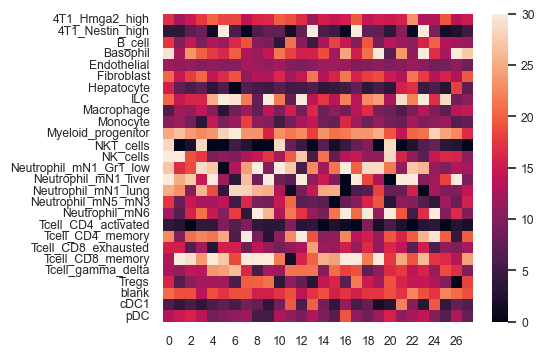

In [15]:
import seaborn as sns
sns.set(font_scale=0.8) 
fig, ax = plt.subplots(figsize=(5,4), dpi=100)
sns.heatmap(mean_exp_df,ax=ax, annot=False, annot_kws={'size': 3},
            yticklabels=_groups, vmin=0, vmax=30)
plt.savefig(os.path.join(figure_folder, 
                         f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_mean_exp_by_bit_final.png"), 
            transparent=True)
fig.show()

In [18]:
_gene_code_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
Trdc,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Ighd,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ighm,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
Gramd3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
Aldh7a1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
blank-68,0,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
blank-69,0,1,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
blank-70,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
blank-71,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [19]:
# convert into standard format:
gene_codes, rest_codes = [], []
for _gene, _code in _gene_code_df.iterrows():
    if 'blank' not in _gene:
        gene_codes.append(np.where(_code.values)[0])
    else:
        rest_codes.append(np.where(_code.values)[0])

In [24]:
# select reasonable subset of rest_codes
# Select blank barcodes randomly
N_blank = 20
#np.random.shuffle(rest_codes)
#blank_codes = rest_codes[:N_blank]
blank_codes, _ = code_selection.find_subset_code_even_coverage(
    rest_codes, code_length, N_blank, N_rounds=20)

Round = 1, variance = 0.19387755102040813
Round = 2, variance = 0.19387755102040813
Round = 3, variance = 0.19387755102040813
Round = 4, variance = 0.19387755102040818
Round = 5, variance = 0.26530612244897955
Round = 6, variance = 0.19387755102040818
Round = 7, variance = 0.26530612244897955
Round = 8, variance = 0.33673469387755117
Round = 9, variance = 0.26530612244897955
Round = 10, variance = 0.26530612244897955
Round = 11, variance = 0.19387755102040813
Round = 12, variance = 0.2653061224489796
Round = 13, variance = 0.19387755102040813
Round = 14, variance = 0.19387755102040813
Round = 15, variance = 0.19387755102040813
Round = 16, variance = 0.12244897959183672
Round = 17, variance = 0.26530612244897955
Round = 18, variance = 0.19387755102040818
Round = 19, variance = 0.12244897959183673
Round = 20, variance = 0.19387755102040813


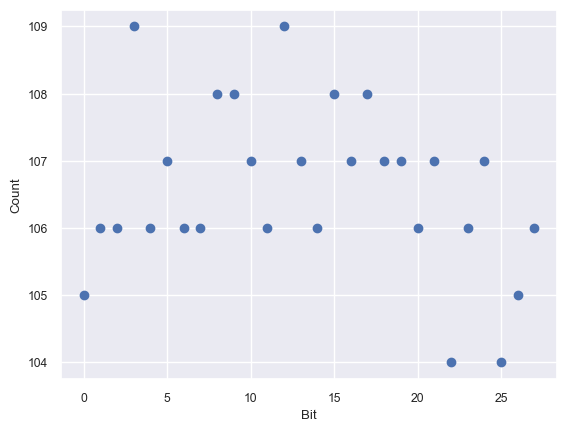

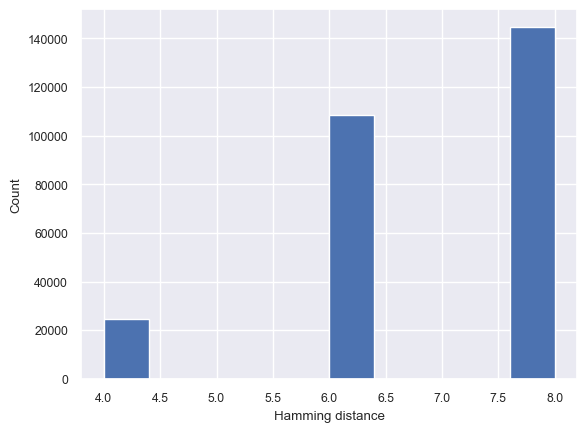

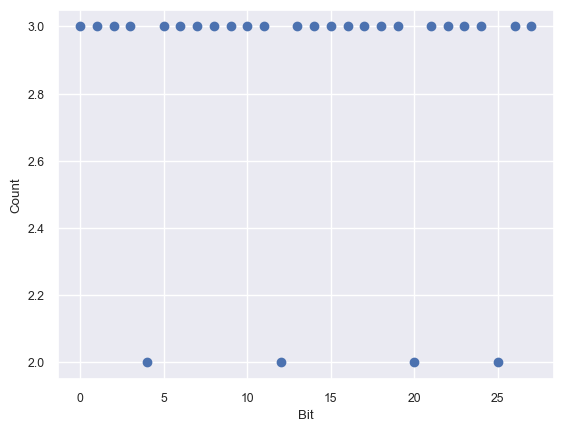

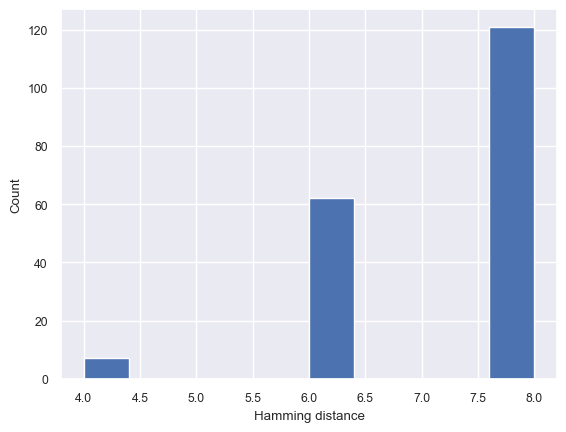

In [25]:
# Plot distributions of gene codes
hamming_code_analysis.plot_bit_coverage(gene_codes, code_length)
hamming_code_analysis.plot_pairwise_hamming_distance_distribution(gene_codes)
# Plot distributions of blank codes
hamming_code_analysis.plot_bit_coverage(blank_codes, code_length)
hamming_code_analysis.plot_pairwise_hamming_distance_distribution(blank_codes)

# Assign genes to bits

In [26]:
# Load the gene expressions for each cell cluster.
# This is a matrix of shape N_clusters x N_genes_of_interest.
# Each element is the expression level of a gene in a cluster.
cluster_gene_exp = kept_gene_df[np.unique(kept_gene_df['Group'])].transpose() #gene_mean_exp_df.values.transpose()
# Normalize the expressions, such that the sum of all expressions are N_clusters.
# The normalization is important for the subsequent simulated annealing.
cluster_gene_exp_normalized = cluster_gene_exp / np.sum(cluster_gene_exp) * cluster_gene_exp.shape[0]

In [27]:
# Load the cluster sizes
cluster_sizes = celltype_num['Level2_ident'].values
# Log normalize the cluster sizes
cluster_sizes_log_normalized = np.log(cluster_sizes + 1) / np.sum(np.log(cluster_sizes + 1))

In [28]:
# Convert the gene codes to binary codes
gene_binary_codes = np.array([cds.on_bits_to_binary_code(c, code_length) for c in gene_codes])

In [29]:
gene_mean_exp_df

,Neutrophil_mN1_Gr1_low,Neutrophil_mN1_lung,B_cell,Macrophage,Neutrophil_mN6,Monocyte,Neutrophil_mN5_mN3,Neutrophil_mN1_liver,Tcell_CD4_memory,NKT_cells,...,4T1_Hmga2_high,Endothelial,Tcell_CD8_exhausted,cDC1,Fibroblast,Hepatocyte,pDC,4T1_Nestin_high,Tcell_gamma_delta,ILC
Name,,,,,,,,,,,,,,,,,,,,,
Mreg,0.040143,0.027879,0.066645,0.158682,0.022618,0.007016,0.614723,0.008359,0.005257,0.005742,...,0.031893,0.019385,0.003265,0.055305,0.064036,0.026689,0.006191,0.000000,0.000000,0.000000
Ddx49,0.021467,0.025378,0.082673,0.087242,0.051959,0.131710,0.010764,0.023404,0.099460,0.081066,...,0.188400,0.078907,0.075510,0.106287,0.102075,0.070218,0.136749,0.155016,0.055316,0.141455
Kdf1,0.000000,0.000000,0.001040,0.000646,0.000000,0.000000,0.000567,0.000000,0.000970,0.001570,...,0.146407,0.000000,0.000000,0.000000,0.009777,0.000000,0.000000,0.016367,0.000000,0.000000
Xcr1,0.000592,0.000336,0.002631,0.004016,0.001497,0.001124,0.000000,0.000000,0.000952,0.004144,...,0.000000,0.004161,0.000000,0.631160,0.000000,0.021294,0.000000,0.000000,0.000000,0.000000
Prdm1,0.012286,0.007914,0.061885,0.213630,0.014026,0.266124,0.058899,0.001286,0.066866,0.139315,...,0.035299,0.171623,0.237238,0.034855,0.019793,0.002619,0.026297,0.000000,0.233927,0.100220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mafb,0.028684,0.041550,0.014462,1.832337,0.056557,1.457920,0.091688,0.008126,0.021058,0.007480,...,0.072680,0.151353,0.050326,0.206281,0.114609,0.070700,0.034394,0.054801,0.009186,0.000000
Mettl1,0.003669,0.004441,0.076294,0.098346,0.017073,0.061911,0.003429,0.007190,0.106292,0.056477,...,0.274990,0.036972,0.083677,0.089094,0.237908,0.118373,0.144914,0.266463,0.066167,0.073743
Axin2,0.000743,0.001478,0.011189,0.001608,0.000417,0.001658,0.000000,0.001162,0.126367,0.076910,...,0.000626,0.020838,0.065357,0.002433,0.185801,0.023300,0.000000,0.000000,0.223236,0.266417


In [30]:
gene_binary_codes.shape

(746, 28)

In [31]:
cluster_gene_exp

Name,Trdc,Ighd,Ighm,Gramd3,Aldh7a1,B4galt6,Klhl14,Chsy3,Fstl1,Apba1,...,C130071C03Rik,A630014C17Rik,Fendrr,Gm44174,4930417O13Rik,D430036J16Rik,1700047M11Rik,4933440M02Rik,Wt1os,Gm14207
4T1_Hmga2_high,0.000950,0.000000,0.005535,0.149769,0.128507,0.017870,0.000000,0.000975,0.011818,0.031194,...,0.159526,0.004629,0.142767,0.000000,0.002830,0.000717,0.000659,0.000000,0.000000,0.005145
4T1_Nestin_high,0.000000,0.000000,0.000000,0.008005,0.315688,0.013439,0.000000,0.002667,0.078138,0.000000,...,0.013313,0.000000,0.005732,0.000000,0.000000,0.003715,0.000000,0.000000,0.016041,0.020964
B_cell,0.005766,0.899805,3.079702,0.833495,0.125186,0.037911,0.349993,0.001795,0.002404,0.034923,...,0.000000,0.005509,0.000168,0.005524,0.019990,0.000918,0.013694,0.002096,0.000000,0.002211
Basophil,0.009944,0.019336,0.267471,0.062936,0.004921,0.017906,0.006303,0.000000,0.000000,0.015856,...,0.000000,0.004393,0.000000,0.000000,0.005636,0.245685,0.012338,0.004543,0.000000,0.000000
Endothelial,0.015243,0.011424,0.296212,0.184072,0.056699,0.093581,0.000000,0.079053,0.115355,0.149189,...,0.000000,0.006346,0.752692,0.000000,0.009114,0.000000,0.134595,0.000000,0.000000,0.053149
Fibroblast,0.010699,0.000000,0.018162,0.124862,0.413623,0.213024,0.000000,0.030558,1.177424,0.038707,...,0.010630,0.001210,0.002397,0.000000,0.001321,0.000000,0.015308,0.000000,0.538093,0.000000
Hepatocyte,0.000000,0.014535,0.648157,0.128767,0.393636,0.062565,0.000000,0.007883,0.000000,0.030164,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024795,0.000000,0.000000,0.000000
ILC,0.065402,0.000000,0.148772,0.028583,0.015686,0.000000,0.000000,0.035826,0.000000,0.000000,...,0.019342,0.031243,0.000000,0.015409,0.074973,0.189079,0.000000,0.000000,0.000000,0.000000
Macrophage,0.003817,0.006848,0.086627,0.067402,0.018453,0.231952,0.002983,0.005261,0.038106,0.201607,...,0.001890,0.000398,0.000000,0.003611,0.006448,0.000802,0.016808,0.000923,0.000760,0.000190
Monocyte,0.000579,0.003574,0.322190,0.075371,0.004022,0.295259,0.001788,0.004409,0.000858,0.456128,...,0.000000,0.000453,0.000409,0.000000,0.002894,0.000697,0.013320,0.001303,0.000844,0.000000


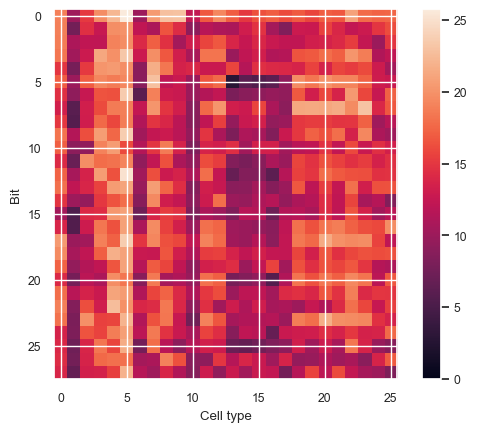

In [32]:
# Plot the distribution of numbers of bright dots in cells before optimization
# The values have the unit dot per million transcripts
cds.plot_dot_distribution(cluster_gene_exp, gene_binary_codes)

In [33]:
cluster_gene_exp_normalized

Name,Trdc,Ighd,Ighm,Gramd3,Aldh7a1,B4galt6,Klhl14,Chsy3,Fstl1,Apba1,...,C130071C03Rik,A630014C17Rik,Fendrr,Gm44174,4930417O13Rik,D430036J16Rik,1700047M11Rik,4933440M02Rik,Wt1os,Gm14207
4T1_Hmga2_high,0.011666,0.000000,0.012143,0.275224,1.784864,0.163279,0.000000,0.060374,0.210777,0.283561,...,19.906863,0.140377,4.063298,0.000000,0.051458,0.041441,0.017199,0.000000,0.000000,0.398257
4T1_Nestin_high,0.000000,0.000000,0.000000,0.014710,4.384670,0.122793,0.000000,0.165105,1.393653,0.000000,...,1.661296,0.000000,0.163139,0.000000,0.000000,0.214788,0.000000,0.000000,0.747889,1.622817
B_cell,0.070796,22.342546,6.756031,1.531680,1.738744,0.346398,23.862674,0.111162,0.042877,0.317458,...,0.000000,0.167039,0.004767,0.103553,0.363500,0.053049,0.357580,0.218933,0.000000,0.171126
Basophil,0.122096,0.480128,0.586758,0.115654,0.068356,0.163611,0.429717,0.000000,0.000000,0.144132,...,0.000000,0.133216,0.000000,0.000000,0.102476,14.203432,0.322168,0.474502,0.000000,0.000000
Endothelial,0.187159,0.283658,0.649808,0.338261,0.787510,0.855070,0.000000,4.894803,2.057457,1.356152,...,0.000000,0.192425,21.422371,0.000000,0.165732,0.000000,3.514453,0.000000,0.000000,4.114181
Fibroblast,0.131359,0.000000,0.039843,0.229454,5.744911,1.946448,0.000000,1.892086,21.000326,0.351855,...,1.326431,0.036687,0.068229,0.000000,0.024027,0.000000,0.399712,0.000000,25.087422,0.000000
Hepatocyte,0.000000,0.360919,1.421879,0.236630,5.467311,0.571669,0.000000,0.488122,0.000000,0.274191,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.647436,0.000000,0.000000,0.000000
ILC,0.803013,0.000000,0.326365,0.052527,0.217869,0.000000,0.000000,2.218261,0.000000,0.000000,...,2.413596,0.947381,0.000000,0.288840,1.363316,10.930972,0.000000,0.000000,0.000000,0.000000
Macrophage,0.046863,0.170027,0.190037,0.123862,0.256301,2.119397,0.203367,0.325762,0.679652,1.832636,...,0.235815,0.012069,0.000000,0.067692,0.117255,0.046387,0.438890,0.096378,0.035416,0.014691
Monocyte,0.007105,0.088738,0.706797,0.138507,0.055857,2.697856,0.121934,0.272984,0.015308,4.146270,...,0.000000,0.013747,0.011646,0.000000,0.052633,0.040322,0.347794,0.136128,0.039354,0.000000


In [34]:
%%time
# Optimize the code assigment to let cells have evenly distributed dots for each bit
# Use the log of cluster sizes to weight the divergence which we want to minimize
best_score, best_codes = cds.optimize_bit_assignments_simulated_annealing_parallel(
    cluster_gene_exp_normalized, cluster_sizes_log_normalized, gene_binary_codes,
    N_test=16, N_threads=15, N_rounds=1, N_iter=2000)

Simulated annealing finished with best score = 104.54135533459429.Simulated annealing finished with best score = 112.32594281022394.
Simulated annealing finished with best score = 107.86140084871383.
Simulated annealing finished with best score = 107.18980697523246.Simulated annealing finished with best score = 106.84169580445995.Simulated annealing finished with best score = 111.97231499054773.Simulated annealing finished with best score = 108.04942054705427.

Simulated annealing finished with best score = 107.41617629226873.


Simulated annealing finished with best score = 114.17070749224433.

Simulated annealing finished with best score = 107.63817276538603.Simulated annealing finished with best score = 99.24807161764211.Simulated annealing finished with best score = 104.25488479074566.Simulated annealing finished with best score = 103.9382047079694.Simulated annealing finished with best score = 113.2842370191807.




Simulated annealing finished with best score = 112.73148714446909

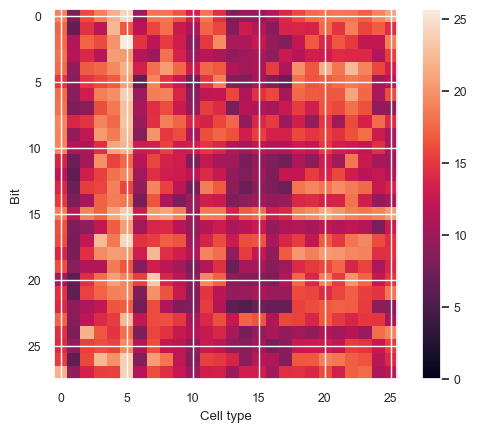

,cell_type_weights
0,0.051588
1,0.050455
2,0.048498
3,0.047632
4,0.046573
5,0.046185
6,0.046144
7,0.044929
8,0.044222
9,0.040752


In [35]:
# The dot distribution is better now.
# There are vertical strip patterns that our optimization didn't change. 
# This is because we can only optimize the distribution across bits.
# The total number of bright dots for each cell type is always 4 x N_expressed_transcripts.
cds.plot_dot_distribution(cluster_gene_exp, best_codes)

# Note that dots in some of the cell types with few cells are not very evenly distributed
pd.DataFrame({'cell_type_weights': cluster_sizes_log_normalized})

# load readouts

In [36]:

from ChromAn.src.library_tools.primers import load_fasta_to_DataFrame

readout_folder = r'/lab/solexa_weissman/puzheng/References/Readouts'
readout_filename = os.path.join(readout_folder, 'updated_Stvs.fasta')
print(f"Loading readouts from file: {readout_filename}")
readouts_all = load_fasta_to_DataFrame(readout_filename)
# select
start_bit = 22
readouts = readouts_all[start_bit:start_bit+num_bits]
readouts.loc[:,'Name'] = np.array([_n.split(' ')[0] for _n in readouts['Name']])
#print(readouts)
readouts_names = list(readouts['Name'])

Loading readouts from file: /lab/solexa_weissman/puzheng/References/Readouts/updated_Stvs.fasta


/tmp/ipykernel_498125/3042375311.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  readouts.loc[:,'Name'] = np.array([_n.split(' ')[0] for _n in readouts['Name']])


## Save readout file

In [37]:
# save readouts
readout_savefile = os.path.join(library_folder, 'readouts.csv')
print(f"Saving readouts to file: {readout_savefile}")
readouts.to_csv(readout_savefile, index=None)

Saving readouts to file: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF2_4T1Primary/readouts.csv


## Save codebook

In [39]:
len(kept_gene_df), len(best_codes)

(746, 746)

In [40]:
# Get a list of gene names including the blank barcodes
gene_names = list(kept_gene_df.index.values) + [f'Blank-{i + 1}' for i in range(N_blank)]

# Get a list of transcript names including the blank barcodes
gene_2_transcript = {_gene:_transcript for _gene, _transcript in kept_gene_df['Transcript'].items()}
transcript_names = [gene_2_transcript[_g] for _g in list(kept_gene_df.index.values)] + [f'' for i in range(N_blank)]

# Convert the barcodes into strings of '1' and '0'.
barcode_binarys = list(best_codes) + [cds.on_bits_to_binary_code(c, code_length) for c in blank_codes]
barcode_strings  = [''.join([str(b) for b in c]) for c in barcode_binarys]

# Write the codebook
print(f"Saving codebook to file: {codebook_file}")
fio.write_merlin_codebook(codebook_file, '1.0', 'MF2-4T1-Primary', readouts_names, gene_names, transcript_names, barcode_strings)

Saving codebook to file: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF2_4T1Primary/codebook.csv


## Manually check codebook now!